In [3]:
%matplotlib inline
import graphviz
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
import numpy as np
from torch import nn

d2l.use_svg_display()

# softmax回归

softmax回归是一种分类算法，网络架构图如下，相比较[线性回归](./linear_regression.ipynb)，其输出层不止一个神经元，这是为了估计输入特征向量$\boldsymbol{x}$所有可能类别的条件概率，使用$o_i$表示类别$i$的输出，其中放射函数(affine function)$f_i$用于计算$o_i$。

$$o_i=\sum_j (x_jw_{ij}) + b_j$$

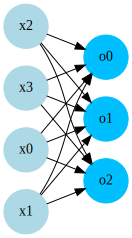

In [4]:
level = [4, 3]
prefix = ["x", "o"]
color = ["lightblue", "deepskyblue"]
G = graphviz.Digraph()
G.attr(rankdir="LR")
G.attr("node", shape="circle", style="filled")
for i, p, c in zip(level, prefix, color):
    for j in range(i):
        G.node(f"{p}{j}", color=c)

for i in range(1, len(level)):
    for j in range(level[i]):
        head = f"{prefix[i]}{j}"
        for k in range(level[i-1]):
            tail = f"{prefix[i-1]}{k}"
            G.edge(tail, head)
G

## softmax运算

softmax回归是一种线性模型，意味着

$$o_i=\boldsymbol{w_i}^\top\boldsymbol{x}+b$$

由于输出是每个类别的概率，因此需要将$o_j$映射为概率$y_i$，并且$y_i$要满足

$$\begin{aligned}
\sum_i y_i&=1\\
y_i &\ge 0
\end{aligned}$$

因此需要规范化$o_i$，通过softmax运算可以将$o_i$映射为概率

$$\hat{y}_i=\frac{exp(o_i)}{\sum_k exp(o_k)}$$

$$\boldsymbol{\hat{y}}=softmax(\boldsymbol{o})$$

那么最终类别为

$$\operatorname*{argmax}_j(\hat{y}_j)=\operatorname*{argmax}_j(o_j)$$

In [5]:
def softmax(X):
    """
    预测n个样本，那么返回一个n*q的矩阵，矩阵的第i行表示第i个样本各个类别的输出值
    需要经过softmax来将输出规范化为概率
    """
    X_exp = torch.exp(X)
    partition =  X_exp.sum(1, keepdim=True)
    return X_exp / partition

X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0879, 0.3298, 0.1046, 0.4595, 0.0181],
         [0.0049, 0.0133, 0.0508, 0.8681, 0.0629]]),
 tensor([1., 1.]))

## 损失函数

### 独热编码

假设数据集$D$包含$n$个类别，对于第$i$个类别使用$n$维向量表示，其中第$i$个元素为1，其他全部是0
$$\begin{bmatrix}
0 \\
\vdots \\
1 \\
\vdots \\
0
\end{bmatrix}$$

这种表示分类数据的方法称为独热编码(one-hot encoding)。

### 损失函数
使用最大似然估计来决定损失函数。对于数据集$D$，由于数据集$D$已经出现了，其出现的概率最大。假设整个数据集$D$有$n$个样本，那么数据集$D$产生的概率为：

$$P(\boldsymbol{Y} | \boldsymbol{X})=\prod_i^nP(\boldsymbol{y^{(i)}}|\boldsymbol{x^{(i)}})$$

相当于优化负对数似然

$$-logP(\boldsymbol{Y}|\boldsymbol{X})=\sum_i^n -logP(\boldsymbol{y^{(i)}}|\boldsymbol{x^{(i)}}) = \sum_i^n l(\boldsymbol{y^{(i)}}, \boldsymbol{\hat{y}^{(i)}})$$

其中对于实际标签$\boldsymbol{y}$和预测标签$\hat{\boldsymbol{y}}$的损失函数为，
$$\begin{aligned}
l(\boldsymbol{y}, \boldsymbol{\hat{y}}) &= -\sum_{j=1}^q y_j log \hat{y}_j \\
&= -\sum_{j=1}^q y_jlog \frac{exp(o_j)}{\sum_{k=1}^{q} exp(o_k)} \\
&= \sum_{j=1}^q y_jlog \sum_{k=1}^{q}exp(o_k)-\sum_{j=1}^{q}y_jo_j \\
&= log\sum_{k=1}^{q}exp(o_k)-\sum_{j=1}^{q}y_jo_j 
\end{aligned}$$

该函数也被称为[交叉熵损失](https://microsoft.github.io/ai-edu/%E5%9F%BA%E7%A1%80%E6%95%99%E7%A8%8B/A2-%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%9F%BA%E6%9C%AC%E5%8E%9F%E7%90%86/%E7%AC%AC1%E6%AD%A5%20-%20%E5%9F%BA%E6%9C%AC%E7%9F%A5%E8%AF%86/03.2-%E4%BA%A4%E5%8F%89%E7%86%B5%E6%8D%9F%E5%A4%B1%E5%87%BD%E6%95%B0/)(cross-entropy loss)

对$o_j$求导有

$$
\frac{\partial l}{\partial o_j}=\frac{exp(o_j)}{\sum_{k=1}^{q} exp(o_k)}-y_j=softmax(\boldsymbol{o})_j-y_j
$$

由于采用独热编码，那么损失函数可以进一步改写为，其中$j$表示标签$\boldsymbol{y}$属于第$j$类

$$
l(\boldsymbol{y}, \boldsymbol{\hat{y}})= -log\hat{y}_j
$$

In [6]:
def cross_entropy(y_hat, y):
    """ 
    y_hat的形状是(n, q)
    y的形状是(n,)
    """
    # print(y_hat.shape, y.shape, type(y_hat), type(y))
    return -torch.log(y_hat[range(len(y_hat)), y])

y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 分类模型的评估

使用精度(accuracy)来评估模型的性能，其中精度等于正确分类的样本数和总样本的比例。

In [7]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.view(y.dtype) == y
    return float(cmp.sum())

accuracy(y_hat, y) / len(y)

0.5

精度能够应用于不同的数据集，包括模型在训练集的精度和测试集的精度，因此添加一个辅助函数来

## Fashion-MNIST数据集

In [8]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
len(mnist_train), len(mnist_test)

(60000, 10000)

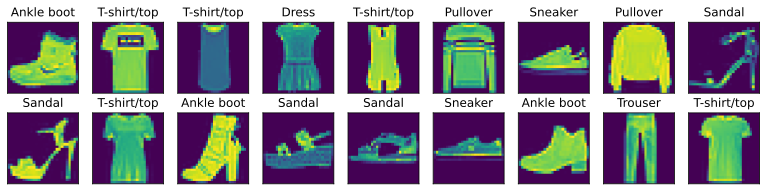

In [9]:
def get_fashion_mnist_labels(labels):  #@save
    return [torchvision.datasets.FashionMNIST.classes[i] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

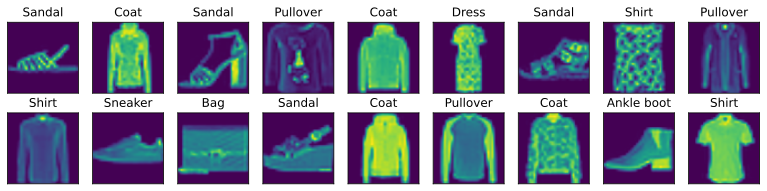

In [10]:
def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

train_iter, test_iter = load_data_fashion_mnist(18, resize=64)
X, y = next(iter(train_iter))
show_images(X.reshape(18, 64, 64), 2, 9, titles=get_fashion_mnist_labels(y))
d2l.plt.show()

## softmax回归的实现

由于是在Fashion-MANIST数据集上训练，并且数据集的每张图片大小为$28\times 28$，定义如下模型参数和模型

In [11]:
num_inputs = 784 # 28*28
num_outputs = 10 # 十个类别

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

训练逻辑如下

In [12]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

下面就能够在Fashion-Manist数据集上训练了

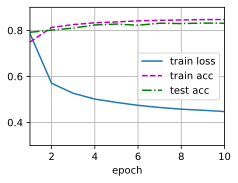

In [14]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

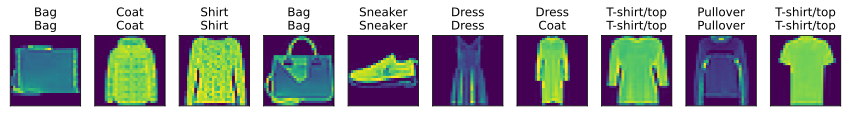

In [ ]:
def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = np.array([true +'\n' + pred for true, pred in zip(trues, preds)])
    indices = np.random.randint(0, len(y), n)
    show_images((X[indices]).reshape((n, 28, 28)), 1, n, titles=titles[indices].tolist())

predict_ch3(net, test_iter, 10)

## softmax回归基于PyTorch的实现


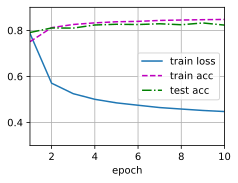

In [ ]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

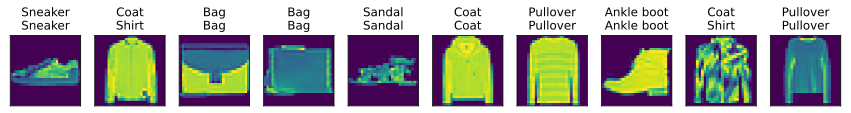

In [ ]:
predict_ch3(net, test_iter, 10)

## 课后习题
- 直接实现了基于数学定义softmax运算的softmax函数。这可能会导致什么问题？函数cross_entropy是根据交叉熵损失函数的定义实现的。它可能有什么问题？

    softmax函数中使用$exp(x)$，如果$x$比较大可能会导致溢出(overflow)，这样会使得分母或者分子变为无穷大(inf)，最后得到的数字可能是0、inf或者NAN。可以通过如下技巧来计算$\hat{y}_j$

    $$\begin{aligned}
    \hat{y}_j &= \frac{exp(o_j-\mathrm{max}(o_k))exp(\mathrm{max}(o_k))}{\sum_k exp(o_k - \mathrm{max}(o_k))}exp(\mathrm{o_k}) \\
    &= \frac{exp(o_j - \mathrm{max}(o_k))}{\sum_k exp(o_k - \mathrm{max}(o_k))}
    \end{aligned}$$

    由于$exp(x)$，其中$x$可能会存在很小的数，导致$exp(x)$接近零，因此在计算交叉熵时求对数可能会得到-inf，可以通过下面的变形来计算交叉熵

    $$\begin{aligned}
    \log(\hat{y}_j) &= \log(\frac{\exp(o_j-\max(o_k))}{\sum_k \exp(o_k - \max(o_k))}) \\
    &= \log(\exp(o_j-\max(o_k)))-\log(\sum_k\exp(o_k - \max(o_k))) \\
    &= o_j - \max(o_k)-\log(\sum_k\exp(o_k-\max(o_k)))
    \end{aligned}$$